# Filtering frequencies

- FFT based filter
- parameter sweep
- kernel based filter


In [1]:
import sys
sys.path.insert(0, '..')

As a basis for this exercise we will use white noise.

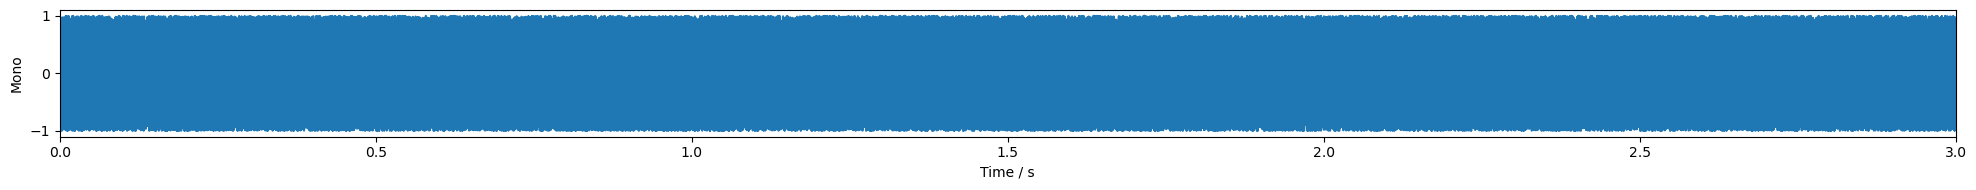

In [2]:
import numpy as np
import wavestacker

white_noise = np.random.rand(3*44100) * 2 - 1
bf = wavestacker.MonoAudioBuffer()
bf.add_audio_data(white_noise)
bf.plot()
bf.play()

And we want to have a look at the spectrum. This functionality is implemented in `wavestacker.plot_spectrum` and can also be used as a method of the `wavestacker.MonoTrack`, `wavestacker.StereoTrack` and `wavestacker.Mixer` objects as `object.spectrum()`.

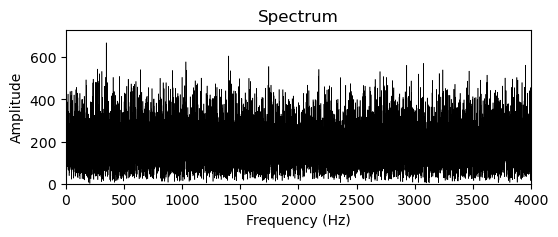

In [12]:
def plot_spectrum(signal): return wavestacker.plot_spectrum(signal, xlim=(0,4000))
fig, ax = plot_spectrum(white_noise)

## FFT based filter

A simple low pass filter can be implemented by applying a fourier transformation, removing frequencies above a cutoff frequency, and then converting the signal back to time space.

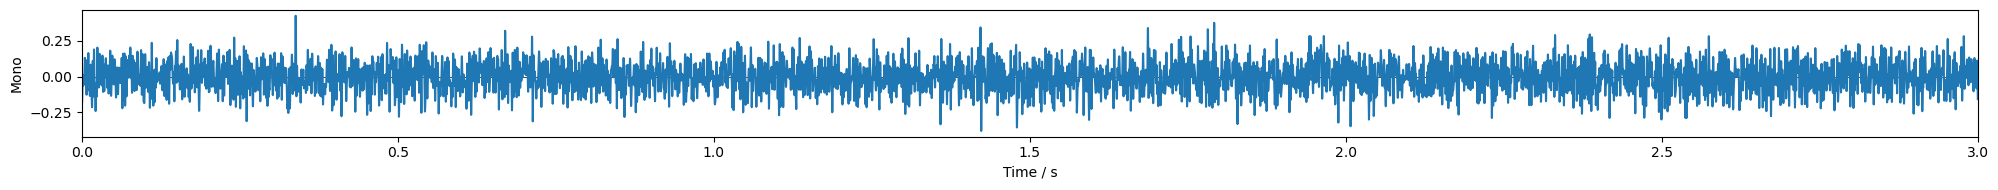

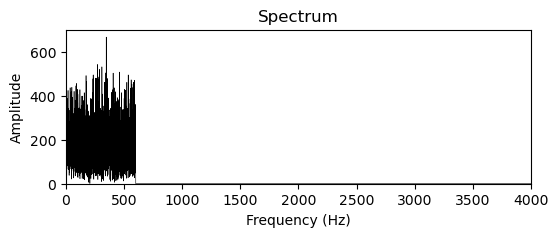

In [32]:
import numpy as np

def lowpass_fft(signal, cutoff_frequency=1000, sample_rate=44100):
    """
    Apply a low-pass filter to the input signal using frequency domain operations.

    Args:
    signal (array_like): The input signal.
    sample_rate (int, optional): The sample rate of the input signal (default: 44100 Hz).
    cutoff_frequency (float, optional): The cutoff frequency of the low-pass filter in Hz (default: 1000 Hz).

    Returns:
    array_like: The filtered signal.
    """
    signal_fft = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), d=1/sample_rate)
    lowpass_mask = np.abs(frequencies) <= cutoff_frequency
    filtered_fft = signal_fft * lowpass_mask
    filtered_signal = np.fft.ifft(filtered_fft)
    return np.real(filtered_signal)

signal = lowpass_fft(white_noise, 600)
bf = wavestacker.MonoAudioBuffer()
bf.add_audio_data(signal)
bf.plot()
fig, ax = plot_spectrum(signal)
bf.play()

That is a rather harsh cutoff. Instead we can fold the frequencies with a sigmoid function to achieve a smoother result.

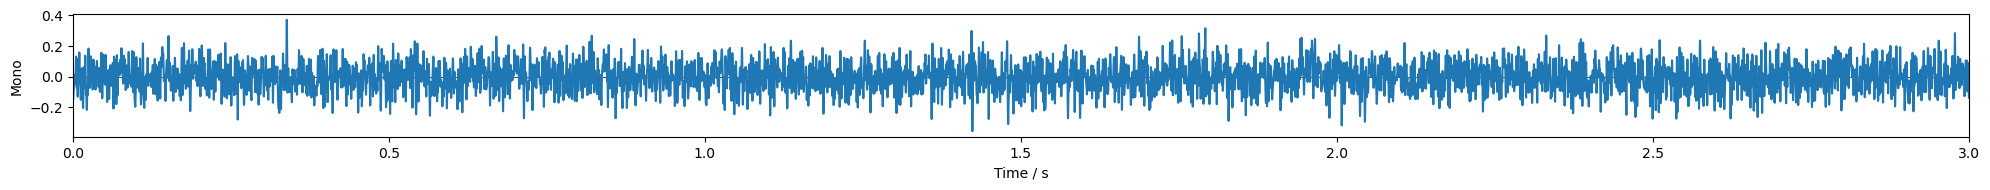

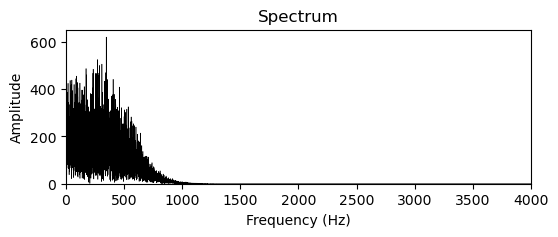

In [34]:
import numpy as np

def lowpass_fft(signal, cutoff_frequency=1000, sample_rate=44100, transition_width=100):
    signal_fft = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), d=1/sample_rate)
    # Sigmoidal decay
    sigmoid = 1 / (1 + np.exp((np.abs(frequencies) - cutoff_frequency) / transition_width))
    filtered_fft = signal_fft * sigmoid
    filtered_signal = np.fft.ifft(filtered_fft)
    return np.real(filtered_signal)

signal = lowpass_fft(white_noise, 600)
bf = wavestacker.MonoAudioBuffer()
bf.add_audio_data(singal)
bf.plot()
fig, ax = plot_spectrum(signal)
bf.play()

And once we are using a function to filter the frequencies, the possibilities are endless. For example adding resonance at the cutoff frequency can be achieved by adding a gaussian. In this case we have to normalise the signal, as the resonance produces values $> 1.0$. If we used a mixer instead of passing the signal directly to the buffer, the mixer would take care of normalising.

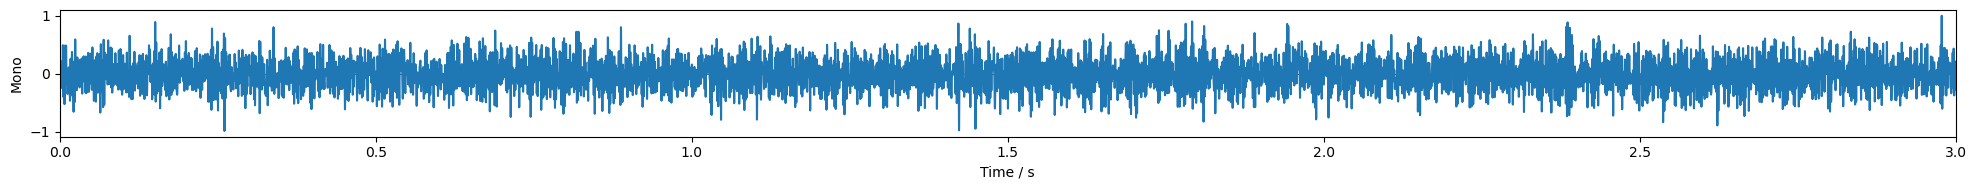

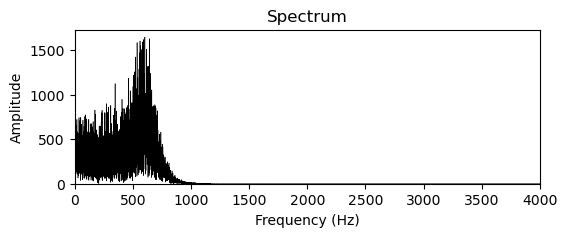

In [36]:
import numpy as np

def resonant_lowpass_fft(signal, cutoff_frequency=1000, sample_rate=44100, transition_width=100, resonance_gain=3, resonance_width=100):
    signal_fft = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), d=1/sample_rate)
    
    # Combine sigmoid and gaussian resonance
    sigmoid = 1 / (1 + np.exp((np.abs(frequencies) - cutoff_frequency) / transition_width))
    gaussian_resonance = resonance_gain * np.exp(-0.5 * ((frequencies - cutoff_frequency) / resonance_width) ** 2)
    filter_response = sigmoid + gaussian_resonance
    
    filtered_fft = signal_fft * filter_response
    filtered_signal = np.fft.ifft(filtered_fft)
    return np.real(filtered_signal)

signal = resonant_lowpass_fft(white_noise, 600)
signal = signal / np.max(np.abs(signal))

bf = wavestacker.MonoAudioBuffer()
bf.add_audio_data(signal)
bf.plot()
fig, ax = plot_spectrum(signal)
bf.play()

Filter sweeps can be implemented by slicing the signal and filtering each segment. But the number of segments has influence on the sound and a sweet spot has to be found. Too little segments makes the steps obvious, too many steps introduce high frequency noise.

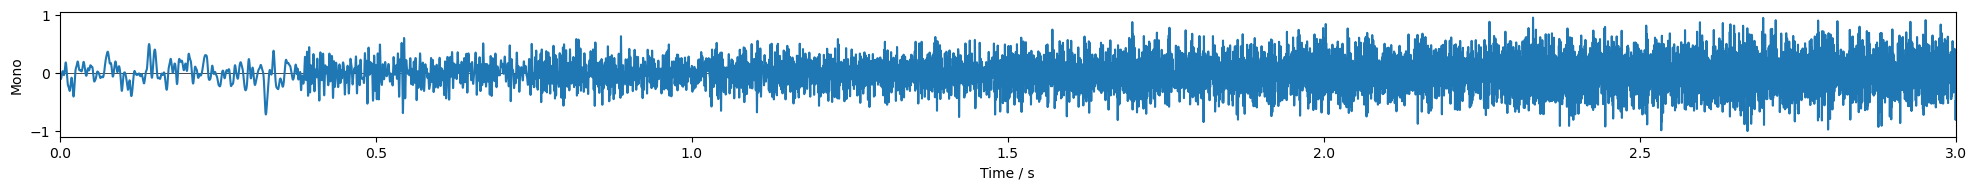

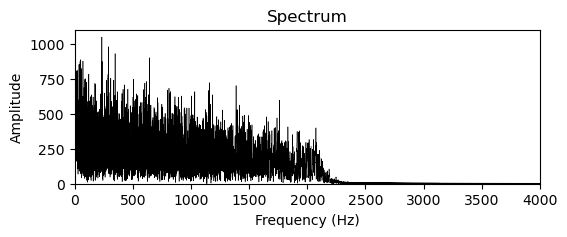

In [102]:
def sweep(signal, filter_function, start_param, end_param, sample_rate=44100, num_segments=100):
    """
    Apply a parameter sweep to the input signal using the specified filter function.

    Args:
    signal (array_like): The input signal.
    filter_function (callable): The filter function to apply. It should accept the signal and a parameter.
    start_param (float): The starting parameter value for the sweep.
    end_param (float): The ending parameter value for the sweep.
    sample_rate (int, optional): The sample rate of the input signal (default: 44100 Hz).
    num_segments (int, optional): The number of segments to divide the signal into for the sweep.

    Returns:
    array_like: The filtered signal.
    """
    segment_length = len(signal) // num_segments
    filtered_signal = np.zeros_like(signal, dtype=np.float64)
    
    for i in range(num_segments):
        start_idx = i * segment_length
        end_idx = start_idx + segment_length
        if i == num_segments - 1: end_idx = len(signal)  # Ensure the last segment includes the remainder
        
        segment = signal[start_idx:end_idx]
        param_value = np.linspace(start_param, end_param, num_segments)[i]
        filtered_segment = filter_function(segment, param_value, sample_rate=sample_rate)
        filtered_signal[start_idx:end_idx] = filtered_segment
    
    return filtered_signal


signal = sweep(white_noise, resonant_lowpass_fft, start_param=0, end_param=2000, num_segments=8)
signal = signal / np.max(np.abs(signal))

bf = wavestacker.MonoAudioBuffer()
bf.add_audio_data(signal)
bf.plot()
fig, ax = plot_spectrum(signal)
bf.play()

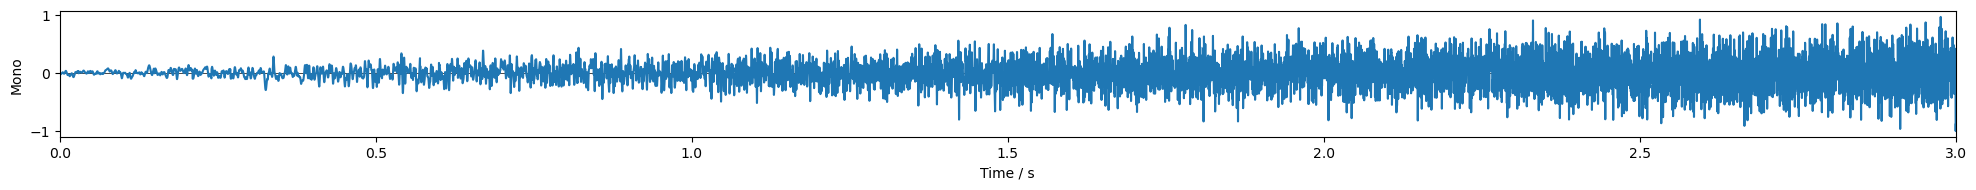

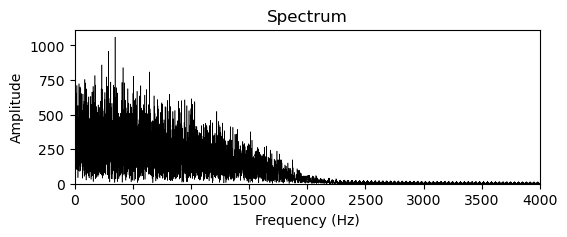

In [103]:
signal = sweep(white_noise, lowpass_fft, start_param=0, end_param=2000, num_segments=100)
signal = signal / np.max(np.abs(signal))

bf = wavestacker.MonoAudioBuffer()
bf.add_audio_data(signal)
bf.plot()
fig, ax = plot_spectrum(signal)
bf.play()

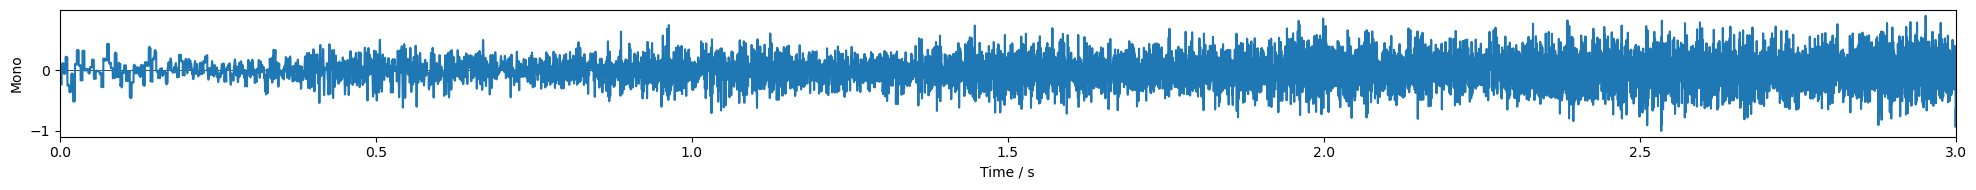

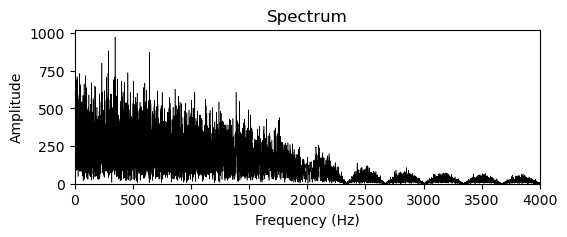

In [104]:
signal = sweep(white_noise, resonant_lowpass_fft, start_param=0, end_param=2000, num_segments=1000)
signal = signal / np.max(np.abs(signal))

bf = wavestacker.MonoAudioBuffer()
bf.add_audio_data(signal)
bf.plot()
fig, ax = plot_spectrum(signal)
bf.play()

## Kernel based filter

Kernel based filters do their magic without a transformation to frequency space. But they do achieve the same results.

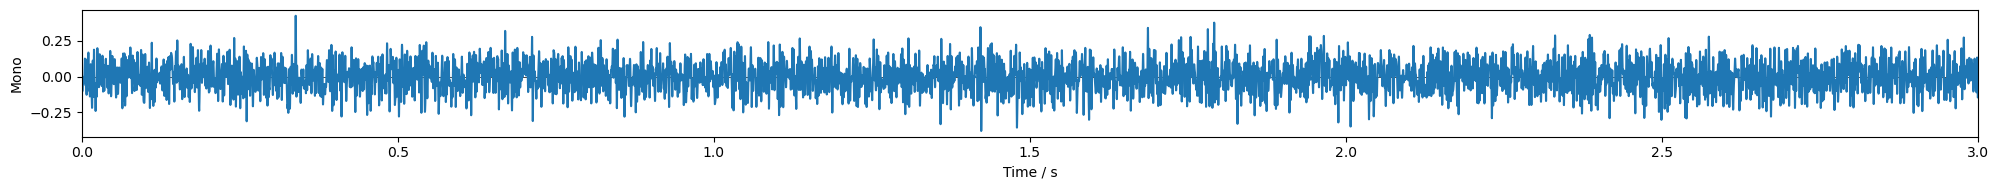

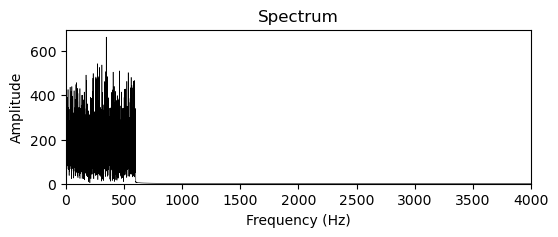

In [111]:
def lowpass_kernel(signal, cutoff_frequency=1000, transition_width=500, sample_rate=44100):
    """
    Apply a low-pass filter to the input signal.

    Args:
    signal (array_like): The input signal.
    sample_rate (int, optional): The sample rate of the input signal (default: 44100 Hz).
    cutoff_frequency (float, optional): The cutoff frequency of the low-pass filter in Hz (default: 1000 Hz).
    transition_width (float, optional): The transition width of the filter in Hz (default: 100 Hz).

    Returns:
    array_like: The filtered signal.
    """
    duration = len(signal) / sample_rate
    t = np.linspace(0, duration, len(signal), endpoint=False)

    # Generate low-pass filter kernel (Gaussian-shaped)
    lowpass_filter = np.sinc(2 * cutoff_frequency * (t - duration / 2))
    lowpass_filter /= np.sum(lowpass_filter)
    
    # Apply Hamming window to the filter kernel for smooth transition
    alpha = transition_width / sample_rate
    hamming_window = 0.54 - 0.46 * np.cos(2 * np.pi * t / duration)
    lowpass_filter *= np.where(np.abs(t - duration / 2) <= alpha / 2, hamming_window, 1)

    # Pad the input signal to ensure output length matches input length
    pad_width = len(lowpass_filter) // 2
    signal_padded = np.pad(signal, (pad_width, pad_width), mode='constant')

    # Convolve padded input signal with low-pass filter
    filtered_signal = np.convolve(signal_padded, lowpass_filter, mode='valid')
    
    return filtered_signal


signal = lowpass_kernel(white_noise, 600)
bf = wavestacker.MonoAudioBuffer()
bf.add_audio_data(signal)
bf.plot()
fig, ax = plot_spectrum(signal)
bf.play()

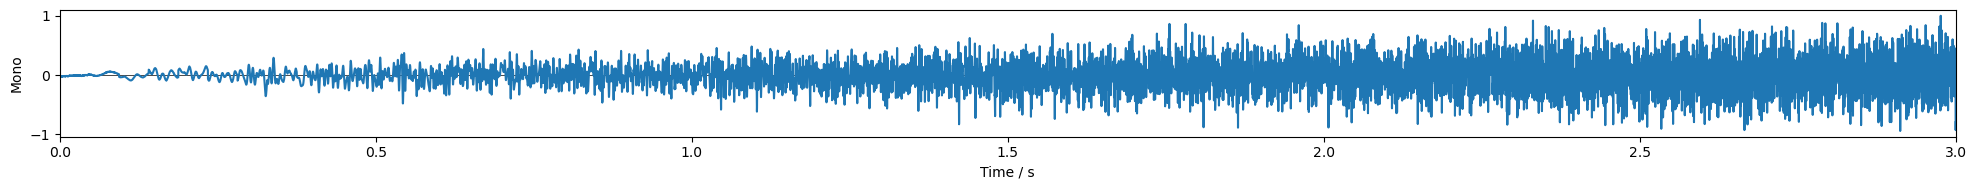

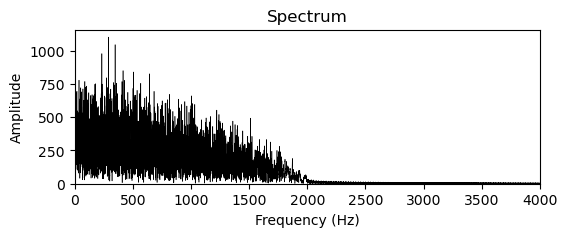

In [112]:
signal = sweep(white_noise, lowpass_kernel, start_param=0, end_param=2000, num_segments=64)
signal = signal / np.max(np.abs(signal))

bf = wavestacker.MonoAudioBuffer()
bf.add_audio_data(signal)
bf.plot()
fig, ax = plot_spectrum(signal)
bf.play()

And as a bonus, a bandpass filter and a inverse filter sweep.

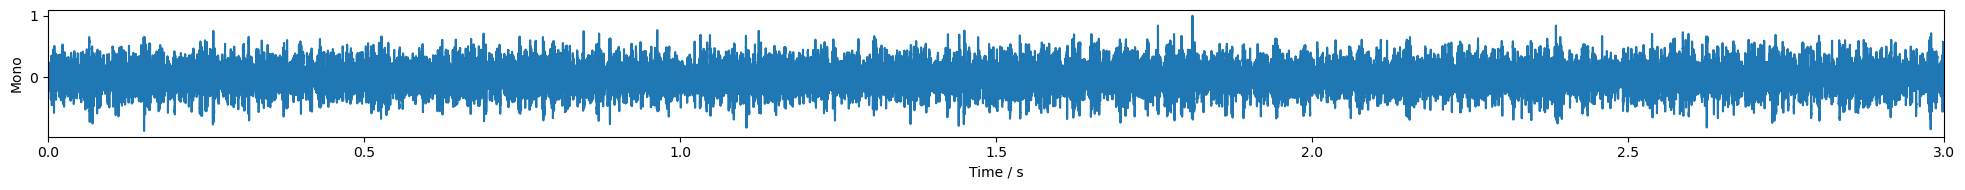

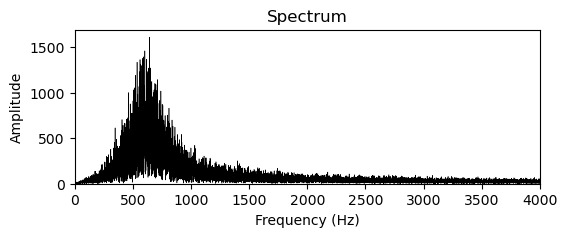

In [113]:
def bandpass_kernel(signal, center_frequency=1000, bandwidth=100, sample_rate=44100):
    """
    Apply a band-pass filter to the input signal.

    Args:
    signal (array_like): The input signal.
    sample_rate (int, optional): The sample rate of the input signal (default: 44100 Hz).
    center_frequency (float, optional): The center frequency of the band-pass filter in Hz (default: 1000 Hz).
    bandwidth (float, optional): The bandwidth of the band-pass filter in Hz (default: 100 Hz).

    Returns:
    array_like: The filtered signal.
    """
    t = np.linspace(0, len(signal) / sample_rate, len(signal), endpoint=False)
    filter_kernel = np.exp(-0.5 * ((2 * np.pi * t * bandwidth) ** 2)) * np.cos(2 * np.pi * t * center_frequency)
    pad_width = len(filter_kernel) // 2
    filtered_signal = np.convolve(np.pad(signal, (pad_width, pad_width), mode='constant'), filter_kernel, mode='same')
    filtered_signal = filtered_signal[:len(signal)]
    return filtered_signal / max(abs(filtered_signal))

bp_noise = bandpass_filter(white_noise, 600)
bf = wavestacker.MonoAudioBuffer()
bf.add_audio_data(bp_noise)
bf.plot()
fig, ax = plot_spectrum(bp_noise)
bf.play()

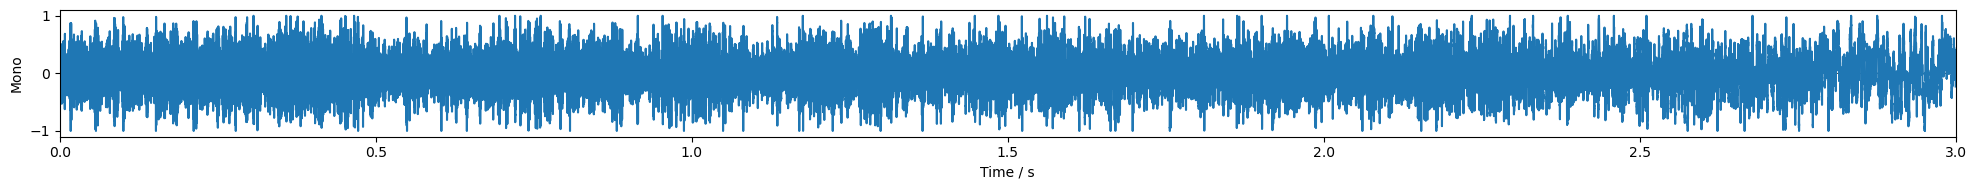

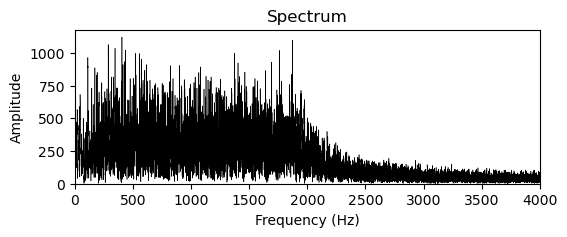

In [109]:
signal = sweep(white_noise, bandpass_kernel, start_param=2000, end_param=0, num_segments=64)
signal = signal / np.max(np.abs(signal))

bf = wavestacker.MonoAudioBuffer()
bf.add_audio_data(signal)
bf.plot()
fig, ax = plot_spectrum(signal)
bf.play()